# 💡 Advanced Affine Transformation in `OpenCV`

This notebook provides a **comprehensive guide** to affine transformations in Python using `OpenCV` and `NumPy`.

`Affine Transformation` preserves points, straight lines, and planes while allowing:
- `Translation`
- `Rotation`
- `Scaling`
- `Shearing`

**What's new in this notebook:**
- Detailed math derivation of affine matrix
- Multiple transformation functions
- Visual demonstrations for rotation, scaling, shearing, translation
- Use cases for image augmentation and preprocessing
- Combined transformations in one matrix

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tools.tools import LearnTools

learn_tools = LearnTools()
%matplotlib inline

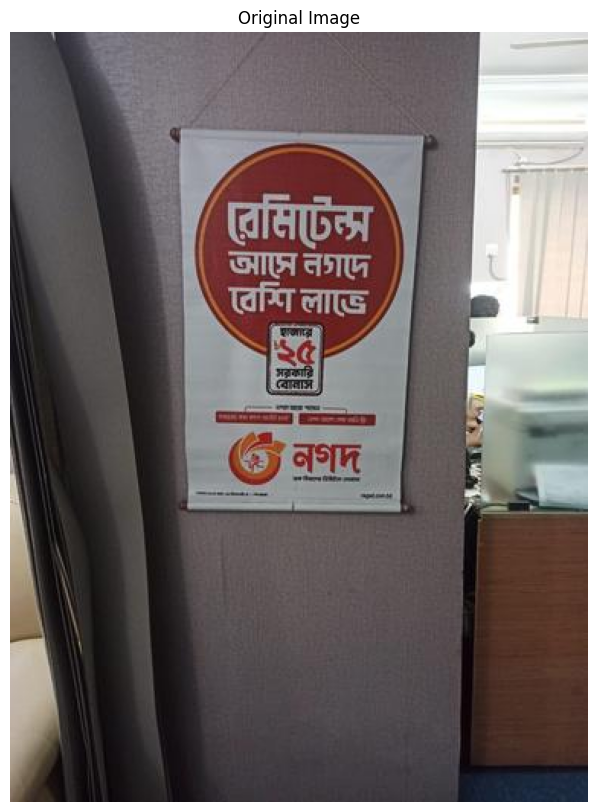

In [86]:
# Load image
# img_url = "https://i.ibb.co/5x276TvQ/1.jpg"
# img_url = "https://i.ibb.co/QjkCQ6Vm/2.jpg"
img_url = "https://i.ibb.co/NyT8LB5/test.jpg"


if os.path.exists('testImage.jpg'):
    image = cv2.imread('testImage.jpg')
else:
    pil_image = await learn_tools.get_image(img_url=img_url, padding=0)
    pil_image.save('testImage.jpg', 'JPEG')
    image = learn_tools.pil_to_cv2(pil_image)

learn_tools.show_multiple_images(
        image_plotting_data=[
            {'title': 'Original Image', 'image': image}
        ]
    )

# Mathematical Background

The **affine transformation** maps points $(x, y)$ to $(x', y')$ using a 2x3 matrix:

$$\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a & b \\ c & d \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix}$$

- `(a, b, c, d)` encode rotation, scaling, and shearing
- `(tx, ty)` encode translation

To compute the affine matrix from points, we need **3 points** on the source image and their corresponding points on the destination image.

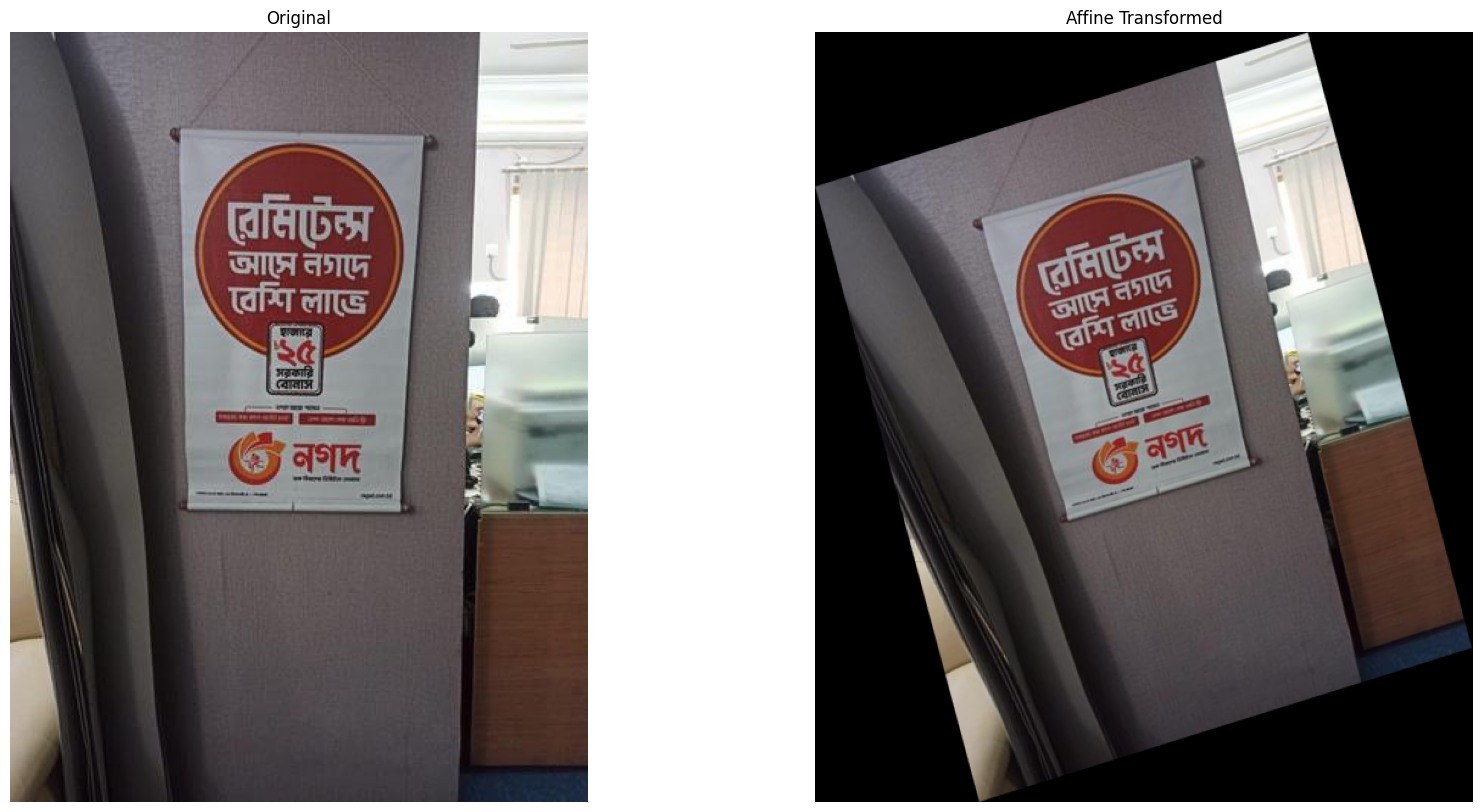

In [87]:
# Building the Original points and desired points
step1 = np.float32([[50, 50], [200, 50], [50, 200]])
step2 = np.float32([[60, 100], [220, 50], [100, 250]])

M = cv2.getAffineTransform(step1, step2) # Compute the affine matrix
rows, cols = image.shape[:2] # Original Image dimensions

# Transform points of ORIGINAL to find new bound
corner_points = np.float32([[0, 0], [cols, 0], [0, rows], [cols, rows]])
transform_corner_points = cv2.transform(np.array([corner_points]), M)[0]

# Creat new box
x_min = int(np.floor(transform_corner_points[:, 0].min()))
x_max = int(np.ceil(transform_corner_points[:, 0].max()))
y_min = int(np.floor(transform_corner_points[:, 1].min()))
y_max = int(np.ceil(transform_corner_points[:, 1].max()))

new_column = x_max - x_min
new_row = y_max - y_min

# Fit matrix to image
M[0, 2] -= x_min
M[1, 2] -= y_min

# Apply transformation
dst = cv2.warpAffine(image, M, (new_column, new_row))

# Display result
learn_tools.show_multiple_images(
        image_plotting_data=[
            {'title': 'Original', 'image': image},
            {'title': 'Affine Transformed', 'image': dst}
        ]
    )

# Translation

Translation moves an image along X and Y axes.

Matrix:
$$\begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \end{bmatrix}$$

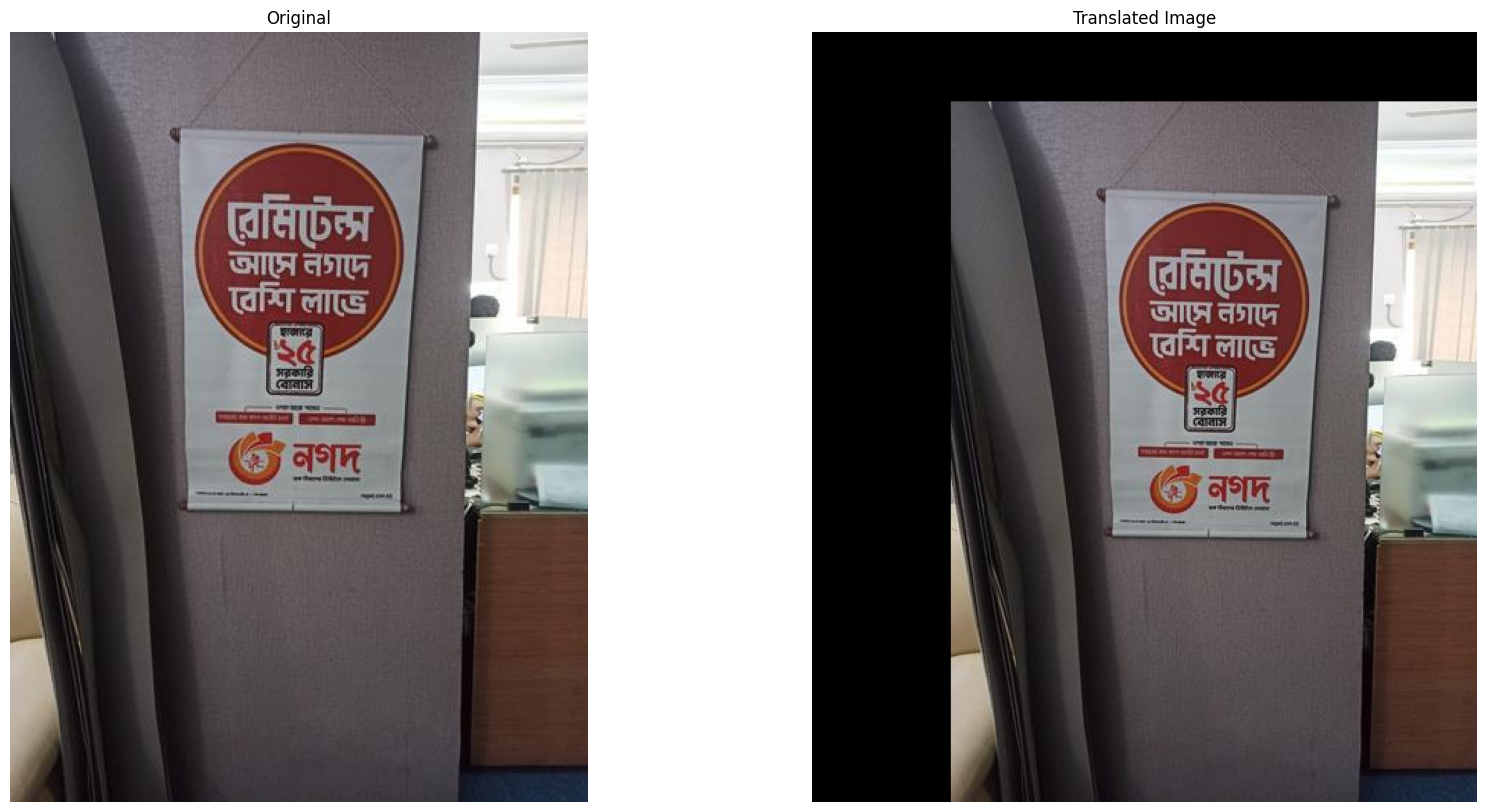

In [102]:
def translate_image(img, translate_x, translate_y):

    row, column = img.shape[:2] # Original Image dimensions

    # Calculate new dimension to fit the translated image
    new_column = column + abs(translate_x)
    new_row = row + abs(translate_y)

    # Calculate Translation matrix
    M = np.float32([[1, 0, max(translate_x, 0)],
                    [0, 1, max(translate_y, 0)]])

    # Apply transformation
    return cv2.warpAffine(img, M, (new_column, new_row))



translate_x_value, translate_y_value = 100, 50
translated_image = translate_image(
        img=image,
        translate_x=translate_x_value,
        translate_y=translate_y_value
    )

# Display result
learn_tools.show_multiple_images(
        image_plotting_data=[
            {'title': 'Original', 'image': image},
            {'title': 'Translated Image', 'image': translated_image}
        ]
    )

# Rotation

Rotate around the image center by angle θ.

Matrix:
$$M = \begin{bmatrix} \cos\theta & -\sin\theta & t_x \\ \sin\theta & \cos\theta & t_y \end{bmatrix}$$

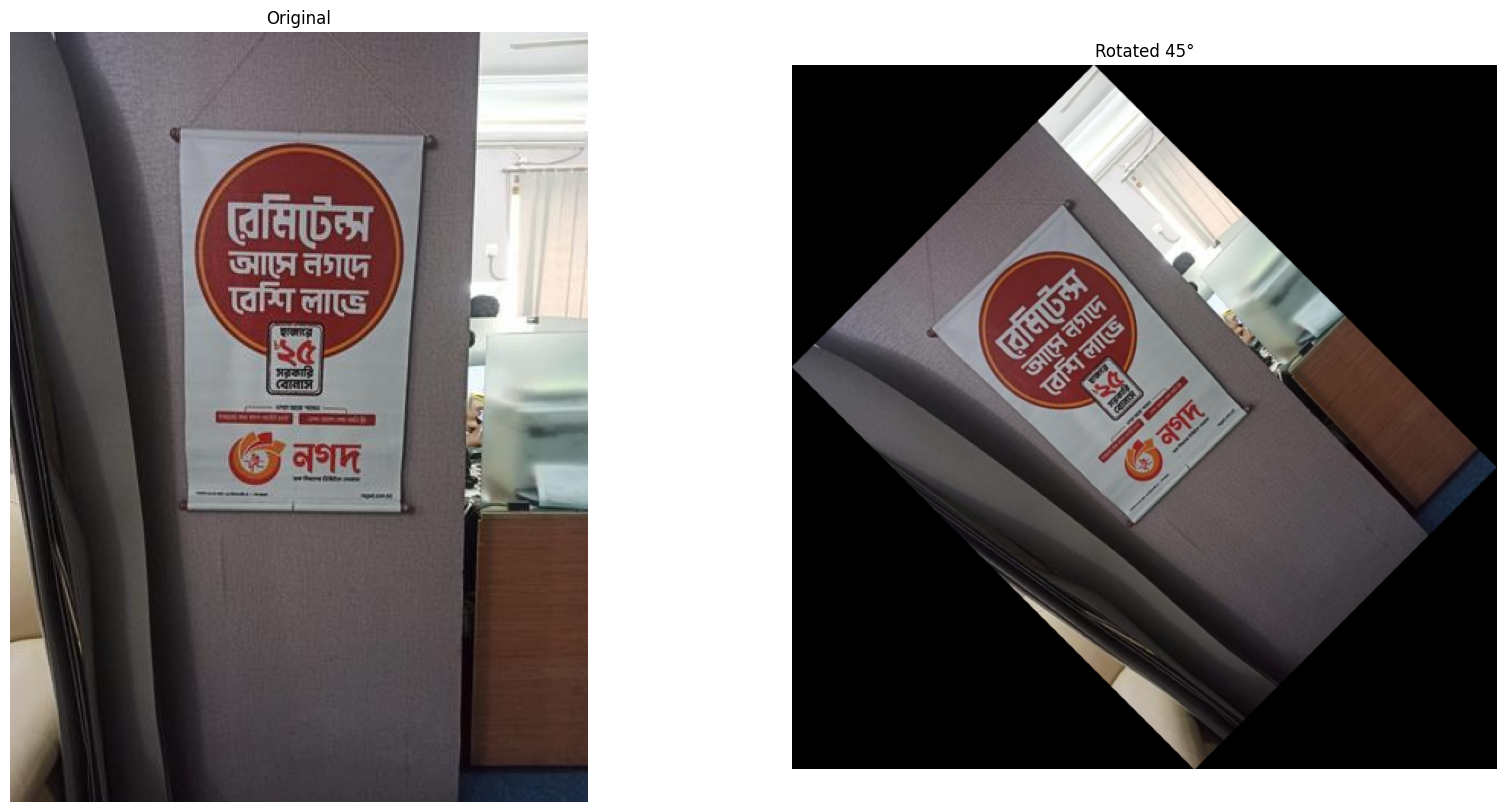

In [103]:
def rotate_image(img, angle, scale=1.0):

    rows, cols = img.shape[:2] # Original Image dimensions
    center = (cols / 2, rows / 2)

    # Calculate rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # New bounding dimension
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_cols = int((rows * sin) + (cols * cos))
    new_rows = int((rows * cos) + (cols * sin))

    # Adjust rotation matrix
    M[0, 2] += (new_cols / 2) - center[0]
    M[1, 2] += (new_rows / 2) - center[1]

    # Apply rotation
    rotated = cv2.warpAffine(img, M, (new_cols, new_rows))
    return rotated

angle_data, scale_data = 45, 1.0
rotated_image = rotate_image(
        img=image,
        angle=angle_data,
        scale=scale_data
    )

# Display result
learn_tools.show_multiple_images(
        image_plotting_data=[
            {'title': 'Original', 'image': image},
            {'title': 'Rotated 45°', 'image': rotated_image}
        ]
    )

# Scaling

Matrix for scaling by `sx` and `sy`:
$$\begin{bmatrix} s_x & 0 & 0 \\ 0 & s_y & 0 \end{bmatrix}$$

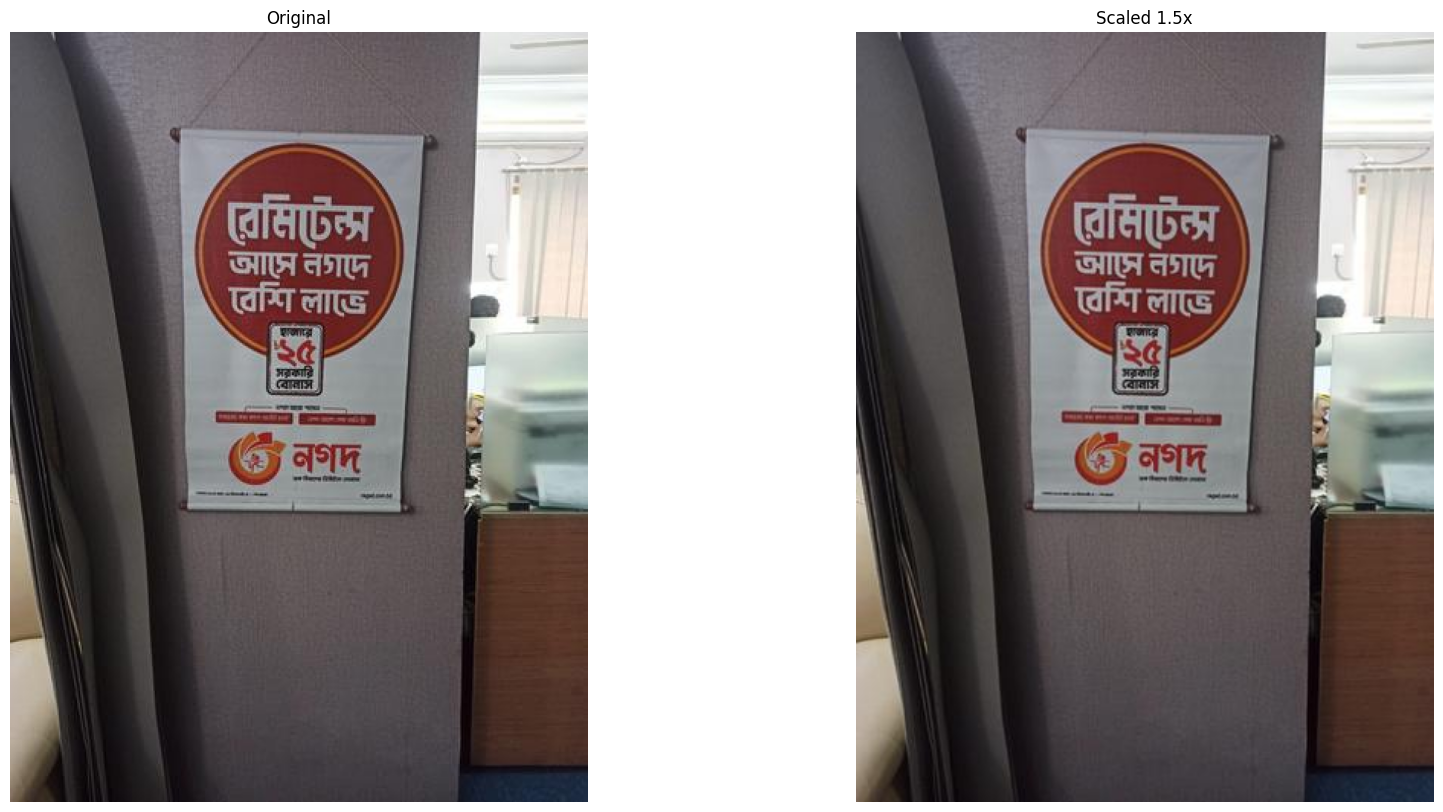

In [104]:
def scale_image(img, scale_x, scale_y):

    rows, cols = img.shape[:2] # Original Image dimensions

    # Calculate dimensions
    new_cols = int(cols * scale_x)
    new_rows = int(rows * scale_y)

    # Calculate scaling matrix
    M = np.float32([[scale_x, 0, 0],
                    [0, scale_y, 0]])

    # Apply scaling
    scaled = cv2.warpAffine(img, M, (new_cols, new_rows))
    return scaled

scale_x_value, scale_y_value = 1.5, 1.5
scaled_image = scale_image(
        img=image,
        scale_x=scale_x_value,
        scale_y=scale_y_value
    )

# Display result
learn_tools.show_multiple_images(
        image_plotting_data=[
            {'title': 'Original', 'image': image},
            {'title': f'Scaled {(scale_x_value+scale_y_value)/2}x', 'image': scaled_image}
        ]
    )

# Shearing

Matrix for shear along X or Y axes:
$$\begin{bmatrix} 1 & sh_x & 0 \\ sh_y & 1 & 0 \end{bmatrix}$$

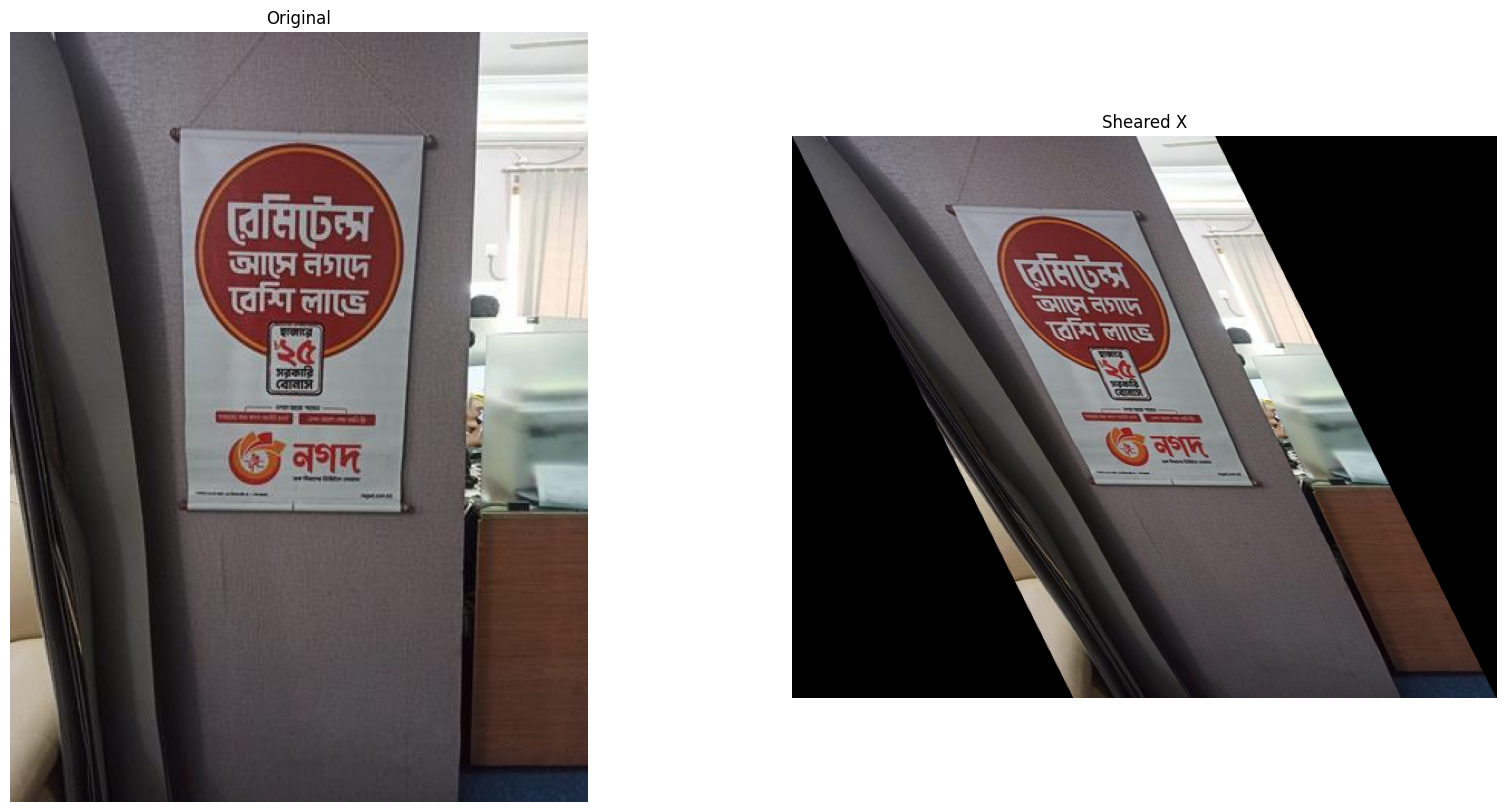

In [110]:
def shear_image(img, shear_x=0.0, shear_y=0.0):

    row, column = img.shape[:2] # Original Image dimensions

    # Calculate Shear matrix
    M = np.float32([[1, shear_x, 0],
                    [shear_y, 1, 0]])

    # Original corners
    corner_points = np.float32([[0, 0], [column, 0], [0, row], [column, row]])
    transform_corner_points = cv2.transform(np.array([corner_points]), M)[0]

    # Calculate bounding box
    x_min = int(np.floor(transform_corner_points[:, 0].min()))
    x_max = int(np.ceil(transform_corner_points[:, 0].max()))
    y_min = int(np.floor(transform_corner_points[:, 1].min()))
    y_max = int(np.ceil(transform_corner_points[:, 1].max()))

    new_column = x_max - x_min
    new_row = y_max - y_min

    # Adjust translation
    M[0, 2] -= x_min
    M[1, 2] -= y_min

    # Apply shear
    sheared = cv2.warpAffine(img, M, (new_column, new_row))
    return sheared


shear_x_value, shear_y_value = 0.5, 0.0
sheared_image = shear_image(
        img=image,
        shear_x=shear_x_value,
        shear_y=shear_y_value
    )

# Display result
learn_tools.show_multiple_images(
        image_plotting_data=[
            {'title': 'Original', 'image': image},
            {'title': f'Sheared {"X & Y" if shear_x_value>0 and shear_y_value>0 else "X" if shear_x_value>0 and shear_y_value<=0 else "Y" if shear_x_value<=0 and shear_y_value>0 else "None"}', 'image': sheared_image}
        ]
    )

# Combined Transformations
Affine transformations can be combined by multiplying matrices.

Example: rotate → scale → translate → shear.

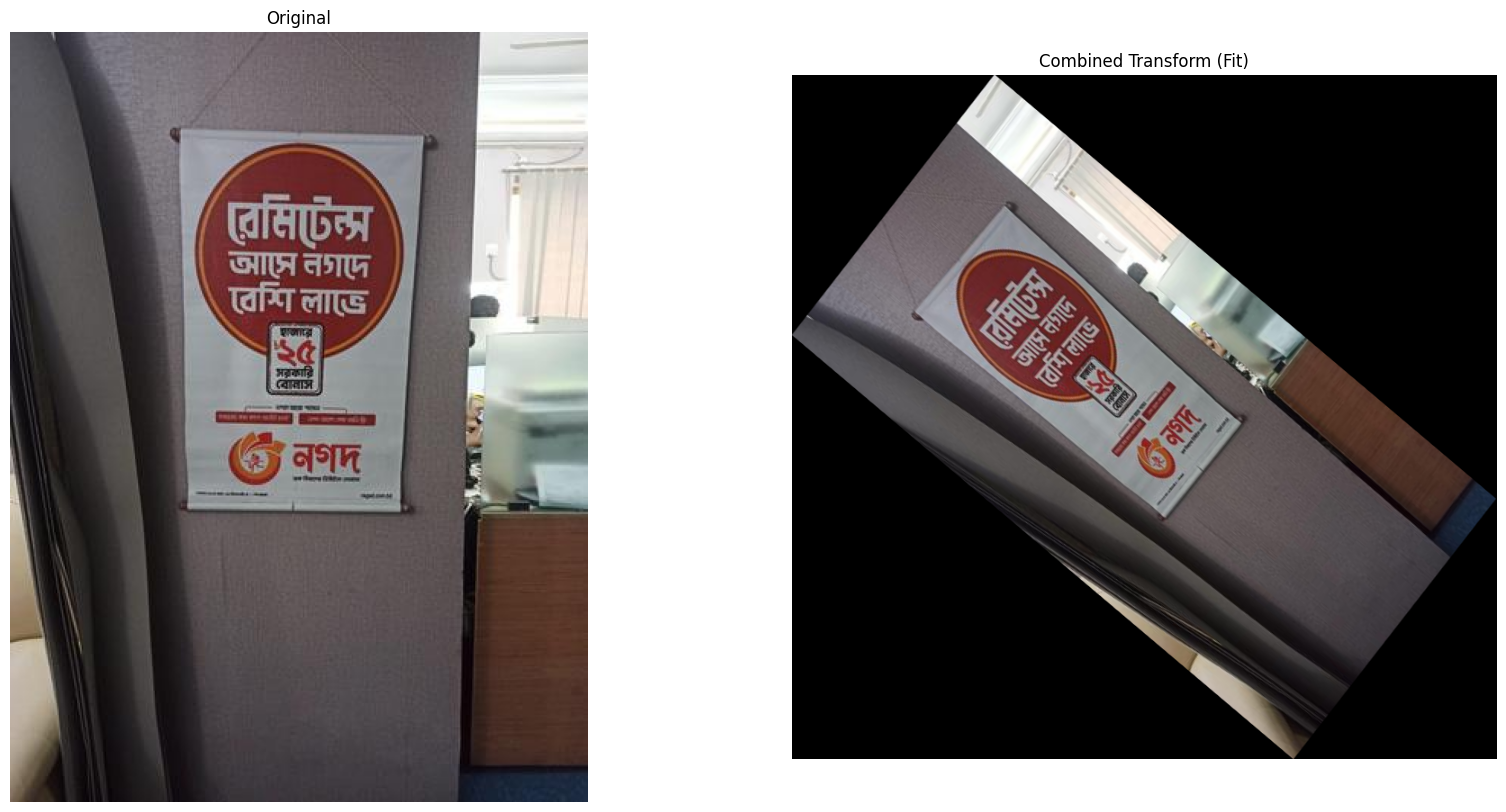

In [113]:
def combined_transform(img, angle=30, scale=1.2, translation_x=50, translation_y=30, shear_x=0.2, shear_y=0.1):
    rows, cols = img.shape[:2] # Original image dimension

    # 1. otation + scaling
    R = cv2.getRotationMatrix2D((cols/2, rows/2), angle, scale)
    R_ext = np.vstack([R, [0, 0, 1]])  # Make 3x3 for combination

    # 2. Shear + translation
    Shear = np.array([[1, shear_x, translation_x],
                      [shear_y, 1, translation_y],
                      [0, 0, 1]])

    # 3. Combined transformation
    M_combined = Shear @ R_ext
    M_final = M_combined[:2, :]

    # 4. Compute transformed image corners for new size
    corners = np.float32([[0, 0], [cols, 0], [0, rows], [cols, rows]])
    transformed_corners = cv2.transform(np.array([corners]), M_final)[0]

    x_min = int(np.floor(transformed_corners[:, 0].min()))
    x_max = int(np.ceil(transformed_corners[:, 0].max()))
    y_min = int(np.floor(transformed_corners[:, 1].min()))
    y_max = int(np.ceil(transformed_corners[:, 1].max()))

    new_cols = x_max - x_min
    new_rows = y_max - y_min

    # 5. Adjust translation to fit full image
    M_final[0, 2] -= x_min
    M_final[1, 2] -= y_min

    # 6. Apply transformation
    transformed_img = cv2.warpAffine(img, M_final, (new_cols, new_rows))

    return transformed_img

combined_img = combined_transform(
        img=image,
        angle=45,
        scale=1.2,
        translation_x=50,
        translation_y=30,
        shear_x=0.3,
        shear_y=0.1
    )

learn_tools.show_multiple_images(
            image_plotting_data=[
            {'title': 'Original', 'image': image},
            {'title': 'Combined Transform (Fit)', 'image': combined_img}
        ]
    )

# Real-World Use Cases
- **Image Augmentation:** Increase dataset diversity for ML models
- **Object Alignment:** Standardize object positions before recognition
- **Medical Imaging:** Correct misaligned scans
- **Satellite Imagery:** Correct geometric distortions and perspective changes